# Домашнее задание. Свёрточные сети

Здесь вам предстоит построить и обучить свою первую свёрточную сеть для классификации изображений на данных CIFAR10.

In [2]:
import tensorflow as tf

from tqdm import tqdm_notebook

print('test')

test


## Данные

CIFAR10
* 60000 RGB изображений размером 32x32x3
* 10 классов: самолёты, собаки, рыбы и т.п.

<img src="https://www.samyzaf.com/ML/cifar10/cifar1.jpg" style="width:60%">

Загрузите данные, разделите их на обучающую и тестовую выборки. Размер тестовой выборки должен быть $10^4$.

In [3]:
import numpy as np
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


Прежде чем приступать к основной работе, стоит убедиться что загруженно именно то, что требовалось:

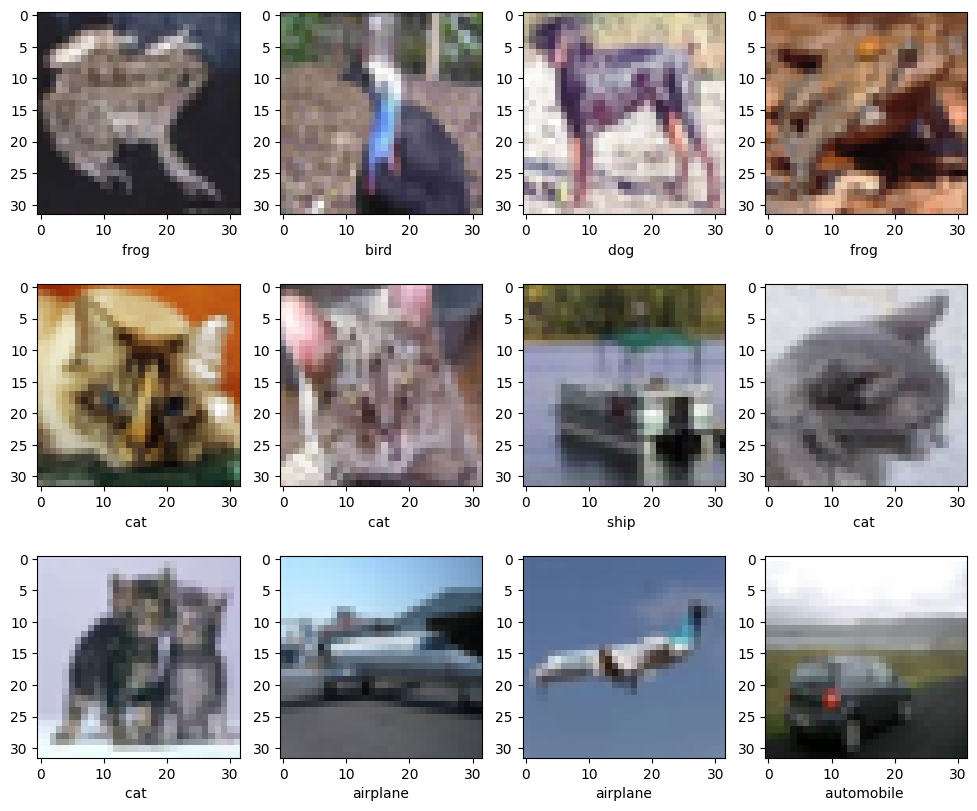

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

## Подготовка данных

Сейчас каждый пиксель изображения закодирован тройкой чисел (RGB) __от 0 до 255__. Однако лучше себя показывает подход, где значения входов нейросети распределены недалеко от 0.

Давайте приведём все данные в диапазон __`[0, 1]`__ — просто разделим на соответствующий коэффициент:

In [5]:
#X_train = X_train / 255
#X_val = X_val / 255
#X_test = X_test / 255

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

Исполните код ниже для проверки, что все выполнено корректно.

In [6]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

## Архитектура сети

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

Создайте полносвязную сеть:

In [7]:
import keras
from keras import layers as L
from keras import backend as K

In [8]:
#model = tf.keras.models.Sequential([
#        tf.keras.layers.Dense(32, activation='relu', input_shape=X_train.shape[1:]),
#        tf.keras.layers.Flatten(),
#        tf.keras.layers.Dense(32, activation='relu'),
#        tf.keras.layers.Dense(32, activation='relu'),
#        tf.keras.layers.Dense(10, activation='softmax')
#])


# Определение модели
#model = tf.keras.models.Sequential([
#    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),  # Слой Flatten, чтобы выровнять входные данные
#    tf.keras.layers.Dense(32, activation='relu'),
#    tf.keras.layers.Dense(32, activation='relu'),
#    tf.keras.layers.Dense(32, activation='relu'),
#    tf.keras.layers.Dense(10, activation='softmax')  # 10 классов для CIFAR-10
#])


model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [9]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

1/1 [==============================] - 0s 46ms/step
Успех!


## Обучение сети

**Задание 1.1 (обязательно)** Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

__Важно:__ поскольку в y_train лежат номера классов, Керасу нужно либо указать sparse функции потерь и метрики оценки качества классификации (`sparse_categorical_crossentropy` и `sparse_categorical_accuracy`), либо конвертировать метки в one-hot формат.

### Полезные советы
* `model.compile` позволяет указать, какие метрики вы хотите вычислять.
* В `model.fit` можно передать валидационную выборку (`validation_data=[X_val, y_val]`), для отслеживания прогресса на ней. Также рекомендуем сохранять результаты в [tensorboard](https://keras.io/callbacks/#tensorboard) или [wandb](https://docs.wandb.ai/integrations/jupyter). **Важно: логи tensorboard не получится без боли посмотреть через colab.** Workaround: скачать логи и запустить tensorboard локально или помучаться [с этим](https://stackoverflow.com/questions/47818822/can-i-use-tensorboard-with-google-colab).
* По умолчанию сеть учится 1 эпоху. Совсем не факт, что вам этого хватит. Число эпох можно настроить в методе `fit` (`epochs`).
* Ещё у Кераса есть много [полезных callback-ов](https://keras.io/callbacks/), которые можно попробовать. Например, автоматическая остановка или подбор скорости обучения.

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

from tensorflow.keras.optimizers.legacy import SGD


y_train, y_val = (keras.utils.to_categorical(y, num_classes=10) for y in (y_train, y_val))

In [11]:
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'), tf.keras.callbacks.TensorBoard(log_dir='./logs'), tf.keras.callbacks.EarlyStopping(patience=20)]


In [12]:
# Компиляция модели
model.compile(
    optimizer=SGD(learning_rate=0.001, momentum=0.9),  # Используем SGD
    loss='categorical_crossentropy',                  # Потеря для многоклассовой классификации
    metrics=['accuracy']                              # Метрика точности
)

In [13]:
# Обучение модели
model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=64,
    callbacks=callbacks,
    validation_data=(X_val, y_val)  # Передача валидационной выборки для оценки точности
)

Epoch 1/64
2500/2500 [==============================] - 3s 1ms/step - loss: 1.9260 - accuracy: 0.3020 - val_loss: 1.7509 - val_accuracy: 0.3746
Epoch 2/64
 152/2500 [>.............................] - ETA: 2s - loss: 1.7495 - accuracy: 0.3882

/Users/kirilldvu/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2500/2500 [==============================] - 3s 1ms/step - loss: 1.7228 - accuracy: 0.3840 - val_loss: 1.6805 - val_accuracy: 0.3920
Epoch 3/64
2500/2500 [==============================] - 3s 1ms/step - loss: 1.6429 - accuracy: 0.4138 - val_loss: 1.6175 - val_accuracy: 0.4224
Epoch 4/64
2500/2500 [==============================] - 3s 1ms/step - loss: 1.5813 - accuracy: 0.4348 - val_loss: 1.5781 - val_accuracy: 0.4403
Epoch 5/64
2500/2500 [==============================] - 3s 1ms/step - loss: 1.5388 - accuracy: 0.4500 - val_loss: 1.5452 - val_accuracy: 0.4479
Epoch 6/64
2500/2500 [==============================] - 3s 1ms/step - loss: 1.5087 - accuracy: 0.4626 - val_loss: 1.5445 - val_accuracy: 0.4476
Epoch 7/64
2500/2500 [==============================] - 3s 1ms/step - loss: 1.4715 - accuracy: 0.4748 - val_loss: 1.5512 - val_accuracy: 0.4473
Epoch 8/64
2500/2500 [==============================] - 3s 1ms/step - loss: 1.4477 - accuracy: 0.4861 - val_loss: 1.5403 - val_accuracy: 0.4484
Epo

А теперь можно проверить качество вашей сети, выполнив код ниже:

In [15]:
from sklearn.metrics import accuracy_score

predict_x=model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.45, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 0s 517us/step

 Test_acc = 0.4793
 Not bad!


## Карманная сверточная сеть

**Задание 1.2 (обязательно)** Реализуйте небольшую свёрточную сеть. Совсем небольшую:
1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [33]:
## TODO
##new_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
##    tf.keras.layers.Dense(128, activation='relu'),
##    tf.keras.layers.Dense(64, activation='relu'),
##    tf.keras.layers.Dense(32, activation='relu'),
##    tf.keras.layers.Dense(10, activation='softmax')
##])

new_model = tf.keras.models.Sequential([
    # Свёрточный слой 3x3 с 10 фильтрами
    tf.keras.layers.Conv2D(10, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    # Max-pooling 2x2
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    # Вытягивание в вектор
    tf.keras.layers.Flatten(),
    # Полносвязный слой на 100 нейронов с нелинейностью
    tf.keras.layers.Dense(100, activation='relu'),
    # Выходной полносвязный слой с softmax
    tf.keras.layers.Dense(10, activation='softmax')
])

In [34]:
##new_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='new_model.{epoch:02d}-{val_loss:.2f}.h5'),
##             tf.keras.callbacks.TensorBoard(log_dir='./logs'),
##             tf.keras.callbacks.EarlyStopping(patience=40)]


# Коллбеки
new_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='new_model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.EarlyStopping(patience=40)
]

In [35]:
## TODO
##new_model.compile(
##    optimizer=SGD(learning_rate=0.001, momentum=0.9),  # Используем SGD
##    loss='categorical_crossentropy',                  # Потеря для многоклассовой классификации
##    metrics=['accuracy']                              # Метрика точности
##)
##new_model.fit(X_train, y_train, batch_size=16, epochs=64, callbacks=new_callbacks, validation_split=0.2)

# Компиляция модели
new_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),  # Используем SGD
    loss='categorical_crossentropy',                                      # Потеря для многоклассовой классификации
    metrics=['accuracy']                                                  # Метрика точности
)

# Обучение модели
new_model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=64,
    callbacks=new_callbacks,
    validation_split=0.2
)

Epoch 1/64
2000/2000 [==============================] - 5s 2ms/step - loss: 1.9202 - accuracy: 0.3157 - val_loss: 1.7071 - val_accuracy: 0.4042
Epoch 2/64
  64/2000 [..............................] - ETA: 4s - loss: 1.7135 - accuracy: 0.3955

/Users/kirilldvu/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2000/2000 [==============================] - 5s 2ms/step - loss: 1.5926 - accuracy: 0.4348 - val_loss: 1.5314 - val_accuracy: 0.4502
Epoch 3/64
2000/2000 [==============================] - 5s 2ms/step - loss: 1.4449 - accuracy: 0.4856 - val_loss: 1.4139 - val_accuracy: 0.4904
Epoch 4/64
2000/2000 [==============================] - 5s 3ms/step - loss: 1.3499 - accuracy: 0.5193 - val_loss: 1.3387 - val_accuracy: 0.5184
Epoch 5/64
2000/2000 [==============================] - 5s 2ms/step - loss: 1.2678 - accuracy: 0.5524 - val_loss: 1.3243 - val_accuracy: 0.5286
Epoch 6/64
2000/2000 [==============================] - 5s 2ms/step - loss: 1.1956 - accuracy: 0.5796 - val_loss: 1.2799 - val_accuracy: 0.5425
Epoch 7/64
2000/2000 [==============================] - 5s 2ms/step - loss: 1.1301 - accuracy: 0.6027 - val_loss: 1.2325 - val_accuracy: 0.5600
Epoch 8/64
2000/2000 [==============================] - 5s 2ms/step - loss: 1.0703 - accuracy: 0.6245 - val_loss: 1.2120 - val_accuracy: 0.5671
Epo

Давайте посмотрим, смогла ли карманная сверточная сеть побить заданный порог по качеству:

In [36]:
from sklearn.metrics import accuracy_score

predict_x = new_model.predict(X_test)
classes_x = np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
assert test_acc > 0.50, "Not good enough. Back to the drawing board :)"
print(" Not bad!")

313/313 [==============================] - 0s 1ms/step

 Test_acc = 0.5793
 Not bad!


## Учимся учить

А теперь научимся сравнивать кривые обучения моделей — зависимости значения accuracy от количества итераций.

Вам потребуется реализовать _экспериментальный стенд_ — вспомогательный код, в который вы сможете подать несколько архитектур и методов обучения, чтобы он их обучил и вывел графики кривых обучения. Это можно сделать с помощью `keras.callbacks` — `TensorBoard` или `History`.

Будьте морально готовы, что на обучение уйдёт _много времени_. Даже если вы ограничитесь 10 эпохами. Пока идёт обучение, вы можете переключиться на другие задания или заняться чем-нибудь приятным: поспать, например.

**Задание 1.3 (опционально)** Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Для удобства напишем класс Evaluator, который принимает в себя дикты виды {имя_оптимайзера: инстанс}, {имя модели: инстанс} и обучает всевозможные комбинации моделей с оптимайзерами при помощи метода fit (попутно записывая логи отдельно для каждой модели). Также пригодится метод evaluate для отображения итоговых скоров.

Пользоваться классом не обязательно. По умолчанию класс использует tensorboard. Если вы выше использовали wandb -- советуем дописать callback.

In [ ]:
class Evaluator(list):
    def __init__(self, models, optimizers='adam', loss=keras.losses.categorical_crossentropy,
                 metrics=[keras.metrics.categorical_accuracy]):
        '''
            models: dict {name: model}
            optimizers: list of optimizers or just one optimizer
        '''
        if not isinstance(models, dict):
            models = {'single_model': models}
        if not isinstance(optimizers, dict):
            optimizers = {str(optimizers.__class__): optimizers}
        super().__init__([(model_name, keras.models.clone_model(model), optimizer_name, optimizer)
                          for model_name, model in models.items()
                          for optimizer_name, optimizer in optimizers.items()])
        for _, model, _, optimizer in self:
            model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X, y, validation_data=(), max_epochs=100, verbose=0, callbacks=[], batch_size=32):
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit(X, y, validation_data=validation_data or None, epochs=max_epochs, verbose=verbose,
                      batch_size=batch_size, callbacks=callbacks + [keras.callbacks.TensorBoard(
                          log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def fit_generator(self, X, y, validation_data=(), max_epochs=100, verbose=1, callbacks=[], batch_size=32):
        datagen = keras.preprocessing.image.ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True
        )
        if not isinstance(callbacks, list):
            callbacks = [callbacks]
        for model_name, model, optimizer_name, optimizer in tqdm_notebook(self):
            model.fit_generator(datagen.flow(X, y, batch_size=batch_size), epochs=max_epochs,
                validation_data=validation_data or None, verbose=verbose,
                callbacks=callbacks + [keras.callbacks.TensorBoard(
                    log_dir='./logs/{}_{}'.format(model_name, optimizer_name))])

    def evaluate(self, X, y, metric):
        for model_name, model, optimizer_name, _ in self:
            print('Final score of {}_{} is {}'.format(model_name, optimizer_name,
                  metric(y_test, model.predict(X_test).argmax(axis=1))))

In [ ]:
!rm -rf ./logs

In [ ]:
from tensorflow.keras import optimizers

## TODO
optimizers = {...}

In [ ]:
evaluator = Evaluator(model, optimizers=optimizers)
evaluator.fit(X_train, y_train, validation_data=(X_val, y_val))
evaluator.evaluate(X_test, y_test, accuracy_score)

In [ ]:
!pwd

Прокомментируйте полученные результаты.

**Задание 1.4 (опционально)** Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях.

Для удобства реализуем класс Models, который по сути будет являться списком моделей с двумя методами: add (добавить слой ко всем моделям) и add_create (создать новую модель на основе базовой с дополнительным слоем). Пользоваться им необязательно, но вдруг :)

In [ ]:
from collections import OrderedDict

class Models(OrderedDict):
    def __init__(self, models):
        if not isinstance(models, dict):
            models = OrderedDict({'base_model': models})
        super().__init__(models)

    def add(self, layer):
        for name, model in self.items():
            model.add(layer)

    def add_create(self, name, layer):
        base_model = next(iter(self.items()))[1]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

    def add_update(self, name, layer):
        base_model = self[next(reversed(self))]
        new_model = keras.models.clone_model(base_model)
        new_model.add(layer)
        self.update({name: new_model})

# Example of usage
# models = Models(keras.Sequential())
# models.add(L.InputLayer(input_shape=(32, 32, 3)))
# models.add(L.Convolution2D(filters=10, kernel_size=(3, 3)))
# models.add(L.MaxPooling2D())
# models.add_create('conv_batchnorm', L.BatchNormalization())
# models.add(L.Activation('relu'))
# ...

In [ ]:
print('test')

Прокомментируйте полученные результаты.

**Задание 1.5 (опционально)** Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху).
Найдите такое значение, при котором модель быстрее достигает точности 55%. **Hint**: используйте early stopping callback.

**Задание 1.6 (опционально)** Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

## Свёрточная нейросеть здорового человека

**Задание 1.7 (обязательно попытаться)** Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

Рекомендуем начать с лучшей модели предыдущего задания и постепенно её улучшать. Вы можете использовать всё, что угодно: любые активации, сколь угодно большие свёрточные слои и глубокие сети. Единственное ограничение: __нельзя использовать предобученные сети и дополнительные данные__.

### Полезные советы
* Для начала, неплохо бы научить что-нибудь побольше, чем 10 фильтров 3x3.
* __Главное правило: одно изменение на эксперимент__. Если у вас есть 2 идеи по улучшению сети, сначала попробуйте их независимо. Может оказаться, что одно из них дало __+10%__ точности а другое __-7%__. А вы так и будете думать, что сделали 2 полезных изменения которые в сумме дают __+3%__. Если какая-то идея не работает — даже если она вам нравится - опишите ее и выкидывайте из дальнейших экспериментов.
* __Be careful or you will dropout__. Дропаут (`L.Dropout`) может позволить вам обучить в несколько раз бОльшую сеть без переобучения, выжав несколько процентов качества. Это круто, но не стоит сразу ставить dropout 50%. Во-первых, слишком сильный дропаут только ухудшит сеть (underfitting). Во-вторых, даже если дропаут улучшает качество, он замедляет обучение. Рекомендуем начинать с небольшого дропаута, быстро провести основные эксперименты, а потом жахнуть в 2 раза больше нейронов и дропаута ~~на ночь~~.
* __Аугментация данных__. Если котика слегка повернуть и подрезать (простите), он всё равно останется котиком. А в керасе есть [удобный класс](https://keras.io/preprocessing/image/), который поставит подрезание котиков на поток. Ещё можно сделать этот трюк в тесте: вертим картинку 10 раз, предсказываем вероятности и усредняем. Только один совет: прежде, чем учить, посмотрите глазами на аугментированные картинки. Если вы сами не можете их различить, то и сеть не сможет.
* __Don't just stack more layers__. Есть более эффективные способы организовать слои, чем простой Sequential. Вот пара идей: [Inception family](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/), [ResNet family](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=9018057983ca), [Densely-connected convolutions](https://arxiv.org/abs/1608.06993). Только не копируйте архитектуру подчистую — вам скорее всего хватит меньшего размера.
* __Долго != плохо__. Более глубокие архитектуры обычно требуют бОльше эпох до сходимости. Это значит, что в первые несколько эпох они могут быть хуже менее глубоких аналогов. Дайте им время, запаситесь чаем и обмажьтесь batch-norm-ом.

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [40]:
val_datagen = ImageDataGenerator()

split = 45000
dg_x_train, dg_x_val = X_train[:split], X_train[split:]
dg_y_train, dg_y_val = y_train[:split], y_train[split:]

In [41]:
## TODO
final_model = tf.keras.models.Sequential([tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

In [42]:
final_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

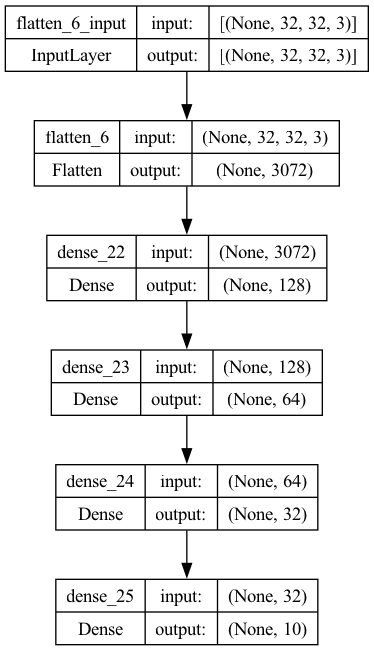

In [43]:
tf.keras.utils.plot_model(final_model, '123.png', show_shapes=True)

In [44]:
## TODO
final_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),  # Используем SGD
    loss='categorical_crossentropy',                                      # Потеря для многоклассовой классификации
    metrics=['accuracy']
)
final_model.fit(datagen.flow(dg_x_train, dg_y_train, batch_size=16), epochs=32, callbacks=final_callbacks, validation_data=val_datagen.flow(dg_x_val, dg_y_val))

Epoch 1/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.9835 - accuracy: 0.2772WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.9835 - accuracy: 0.2772
Epoch 2/32
2492/2500 [============================>.] - ETA: 0s - loss: 1.8045 - accuracy: 0.3497WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.8043 - accuracy: 0.3497
Epoch 3/32
2494/2500 [============================>.] - ETA: 0s - loss: 1.7369 - accuracy: 0.3771WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.7368 - accuracy: 0.3769
Epoch 4/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.6964 - accuracy: 0.3891WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.6964 - accuracy: 0.3890
Epoch 5/32
2489/2500 [============================>.] - ETA: 0s - loss: 1.6648 - accuracy: 0.4002WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.6651 - accuracy: 0.4002
Epoch 6/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.6392 - accuracy: 0.4116WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.6392 - accuracy: 0.4116
Epoch 7/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.6209 - accuracy: 0.4185WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.6209 - accuracy: 0.4185
Epoch 8/32
2493/2500 [============================>.] - ETA: 0s - loss: 1.6014 - accuracy: 0.4269WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.6018 - accuracy: 0.4268
Epoch 9/32
2500/2500 [==============================] - ETA: 0s - loss: 1.5875 - accuracy: 0.4295WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5875 - accuracy: 0.4295
Epoch 10/32
2491/2500 [============================>.] - ETA: 0s - loss: 1.5754 - accuracy: 0.4351WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5754 - accuracy: 0.4353
Epoch 11/32
2489/2500 [============================>.] - ETA: 0s - loss: 1.5624 - accuracy: 0.4393WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5632 - accuracy: 0.4391
Epoch 12/32
2488/2500 [============================>.] - ETA: 0s - loss: 1.5515 - accuracy: 0.4458WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5515 - accuracy: 0.4456
Epoch 13/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.5463 - accuracy: 0.4478WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5461 - accuracy: 0.4479
Epoch 14/32
2496/2500 [============================>.] - ETA: 0s - loss: 1.5272 - accuracy: 0.4522WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5274 - accuracy: 0.4521
Epoch 15/32
2494/2500 [============================>.] - ETA: 0s - loss: 1.5195 - accuracy: 0.4550WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5196 - accuracy: 0.4549
Epoch 16/32
2493/2500 [============================>.] - ETA: 0s - loss: 1.5155 - accuracy: 0.4555WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5155 - accuracy: 0.4555
Epoch 17/32
2489/2500 [============================>.] - ETA: 0s - loss: 1.5062 - accuracy: 0.4604WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.5052 - accuracy: 0.4607
Epoch 18/32
2488/2500 [============================>.] - ETA: 0s - loss: 1.4989 - accuracy: 0.4637WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4991 - accuracy: 0.4635
Epoch 19/32
2494/2500 [============================>.] - ETA: 0s - loss: 1.4954 - accuracy: 0.4648WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4956 - accuracy: 0.4648
Epoch 20/32
2494/2500 [============================>.] - ETA: 0s - loss: 1.4842 - accuracy: 0.4695WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4844 - accuracy: 0.4694
Epoch 21/32
2494/2500 [============================>.] - ETA: 0s - loss: 1.4773 - accuracy: 0.4732WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4769 - accuracy: 0.4732
Epoch 22/32
2491/2500 [============================>.] - ETA: 0s - loss: 1.4695 - accuracy: 0.4745WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4691 - accuracy: 0.4747
Epoch 23/32
2490/2500 [============================>.] - ETA: 0s - loss: 1.4657 - accuracy: 0.4775WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4656 - accuracy: 0.4775
Epoch 24/32
2496/2500 [============================>.] - ETA: 0s - loss: 1.4607 - accuracy: 0.4760WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4609 - accuracy: 0.4759
Epoch 25/32
2498/2500 [============================>.] - ETA: 0s - loss: 1.4545 - accuracy: 0.4795WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4545 - accuracy: 0.4796
Epoch 26/32
2499/2500 [============================>.] - ETA: 0s - loss: 1.4526 - accuracy: 0.4782WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4525 - accuracy: 0.4783
Epoch 27/32
2493/2500 [============================>.] - ETA: 0s - loss: 1.4428 - accuracy: 0.4831WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4428 - accuracy: 0.4831
Epoch 28/32
2497/2500 [============================>.] - ETA: 0s - loss: 1.4392 - accuracy: 0.4842WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4390 - accuracy: 0.4843
Epoch 29/32
2494/2500 [============================>.] - ETA: 0s - loss: 1.4328 - accuracy: 0.4882WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4330 - accuracy: 0.4882
Epoch 30/32
2495/2500 [============================>.] - ETA: 0s - loss: 1.4284 - accuracy: 0.4864WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4282 - accuracy: 0.4864
Epoch 31/32
2492/2500 [============================>.] - ETA: 0s - loss: 1.4215 - accuracy: 0.4952WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4215 - accuracy: 0.4952
Epoch 32/32
2491/2500 [============================>.] - ETA: 0s - loss: 1.4242 - accuracy: 0.4906WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy


2500/2500 [==============================] - 10s 4ms/step - loss: 1.4242 - accuracy: 0.4907


Момент истины: проверьте, какого качества достигла ваша сеть.

In [45]:
from sklearn.metrics import accuracy_score

predict_x=final_model.predict(X_test)
classes_x=np.argmax(predict_x,axis=1)

test_acc = accuracy_score(y_test, classes_x)
print("\n Test_acc =", test_acc)
if test_acc > 0.8:
    print("Это победа!")

313/313 [==============================] - 0s 544us/step

 Test_acc = 0.5058


А теперь, опишите свои <s>ощущения</s> результаты от проведенных экспериментов.

__В рамках реализации задания 1.1 реализовано:__
    
1. Подготовка меток данных:
Метки классов для тренировочной и валидационной выборок (y_train и y_val) преобразуются в формат one-hot encoding с помощью keras.utils.to_categorical, чтобы их можно было использовать с функцией потерь categorical_crossentropy.
2. Использование коллбеков для управления обучением:
 • ModelCheckpoint: сохраняет модель после каждой эпохи с именем файла, включающим номер эпохи и значение функции потерь на валидации.
 • TensorBoard: логирует данные обучения, которые можно визуализировать в TensorBoard.
 • EarlyStopping: автоматически останавливает обучение, если валидационная ошибка не улучшается на протяжении 20 эпох, чтобы избежать переобучения.
3. Настройка обучения модели:
Модель компилируется с оптимизатором SGD (градиентный спуск с импульсом), функцией потерь categorical_crossentropy для многоклассовой классификации и метрикой точности (accuracy) для отслеживания производительности.
4. Оценка модели:
После обучения модель предсказывает метки классов на тестовом наборе данных (X_test). Предсказанные метки сравниваются с истинными (y_test) с помощью метрики точности accuracy_score из sklearn.
5. Условие для достижения цели:
Код проверяет, достигла ли точность на тестовых данных (test_acc) порога 45%. Если точность меньше, выводится сообщение об ошибке; иначе программа завершается с сообщением "Not bad!".


__В рамках исполнения задания 1.2 реализовано:__

	1. Добавлен сверточный слой: Conv2D с фильтрами 3x3 и 10 фильтрами.
	2. Добавлен MaxPooling слой: MaxPooling2D с пулом 2x2.
	3. Добавлен слой Flatten: чтобы преобразовать данные в вектор после свёртки и пуллинга.
	4. Полносвязный слой на 100 нейронов с активацией ReLU.
	5. Выходной слой: полносвязный с 10 классами и активацией softmax.